# **Imported libraries**

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, classification_report
from imblearn.combine import SMOTEENN
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import os
import math
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [31]:
import imblearn

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    make_scorer,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score


from sklearn.impute import SimpleImputer
from sklearn import metrics

from sklearn.model_selection import cross_val_score


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


pd.set_option("display.max_columns", None)


pd.set_option("display.float_format", lambda x: "%.3f" % x)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# **Loading Data**

In [32]:
X_train = pd.read_csv('train_data_scaled.csv')
X_val = pd.read_csv('val_data_scaled.csv')
test_data_scaled = pd.read_csv('test_data_scaled.csv')
y_train = pd.read_csv('y_train.csv')
y_val = pd.read_csv('y_val.csv')

In [33]:
y_val = y_val.set_index('Claim Identifier')['Claim Injury Type']
y_train = y_train.set_index('Claim Identifier')['Claim Injury Type']
X_val = X_val.set_index('Claim Identifier')
X_train = X_train.set_index('Claim Identifier')
test_data_scaled = test_data_scaled.set_index('Claim Identifier')

In [34]:
target_mapping = {
    0: '1. CANCELLED',
    1: '2. NON-COMP',
    2: '3. MED ONLY',
    3: '4. TEMPORARY',
    4: '5. PPD SCH LOSS',
    5: '6. PPD NSL',
    6: '7. PTD',
    7: '8. DEATH'
}

### **SMOTE - Synthetic Minority Oversampling Technique**

In [35]:
print("Class distribution:", Counter(y_train))

Class distribution: Counter({1: 203754, 3: 103955, 2: 48234, 4: 33796, 0: 8734, 5: 2948, 7: 329, 6: 68})


**The target distribution is definitely imbalanced.**

In [36]:
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", Counter(y_train_oversampled))

Class distribution after SMOTE: Counter({1: 203754, 3: 203754, 2: 203754, 4: 203754, 0: 203754, 5: 203754, 7: 203754, 6: 203754})


In [37]:
sampling_strategy = {
    0: 20000,  
    1: 203754, 
    2: 48234,  
    3: 103955, 
    4: 33796, 
    5: 10000, 
    6: 2500,   
    7: 5000   
}

In [38]:
sm = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=5, random_state=42)
X_train_resampled_personalized, y_train_resampled_personalized= sm.fit_resample(X_train, y_train)

### **Undersampling**

In [39]:
undersampler = RandomUnderSampler(random_state=42)
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)
print("Class distribution after undersampling:", Counter(y_train_undersampled))

Class distribution after undersampling: Counter({0: 68, 1: 68, 2: 68, 3: 68, 4: 68, 5: 68, 6: 68, 7: 68})


### **Oversampling and Undersampling**

In [40]:
# smote_enn = SMOTEENN(random_state=42)
# X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)
# print("Class distribution after SMOTEENN:", Counter(y_train_resampled))

### **Class Weighting**

In [41]:
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
# print("Class weights:", class_weight_dict)

### **Models Evaluation**

In [42]:
def trained_models(models, X_train, y_train, X_val, y_val):

    results = {}
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        
        # Predict on training set
        y_train_pred_encoded = model.predict(X_train)
        
        # Predict on validation set
        y_val_pred_encoded = model.predict(X_val)
        
        # Store results
        results[name] = {
            'model': model,
            'f1_macro_train': f1_score(y_train, y_train_pred_encoded, average='macro'),
            'accuracy_train': accuracy_score(y_train, y_train_pred_encoded),
            'f1_macro_val': f1_score(y_val, y_val_pred_encoded, average='macro'),
            'accuracy_val': accuracy_score(y_val, y_val_pred_encoded)
        }
    
    print("\nModel Evaluation Results:")
    for model_name, metrics in results.items():
        print(
            f"{model_name}: "
            f"Train F1 macro = {metrics['f1_macro_train']:.4f}, "
            f"Train Accuracy = {metrics['accuracy_train']:.4f}, "
            f"Validation F1 macro = {metrics['f1_macro_val']:.4f}, "
            f"Validation Accuracy = {metrics['accuracy_val']:.4f}"
        )
    
    return results

In [43]:
def generate_predictions(models, test_data_scaled, target_mapping, output_prefix=""):
    
    predictions = {}
    
    for name, model in models.items():
        print(f"Predicting with {name}...")
        # Predict on the test dataset
        preds = model.predict(test_data_scaled)
        predictions[name] = preds
    
    for name, preds in predictions.items():
        # Reverse encode the predictions using target_mapping
        preds_decoded = [target_mapping[pred] for pred in preds]
        
        # Create a DataFrame for predictions
        predictions_df = pd.DataFrame({
            'Claim Identifier': test_data_scaled.index,
            'Claim Injury Type': preds_decoded
        })
        
        # Save to CSV
        predictions_df.to_csv(f'{name}_predictions.csv', index=False)
        print(f"Predictions for {name} saved to '{name}_predictions.csv'")
    
    return predictions

In [44]:
models= {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Bagging": BaggingClassifier(random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "GBM": GradientBoostingClassifier(random_state=42),
    "XGB": XGBClassifier(random_state=42),
    "Neural Network": MLPClassifier(random_state=42)
}

In [45]:
results = trained_models(models, X_train, y_train, X_val, y_val)

Training Logistic Regression...
Training Random Forest...
Training Decision Tree...
Training Bagging...
Training KNeighborsClassifier...
Training GBM...
Training XGB...
Training Neural Network...

Model Evaluation Results:
Logistic Regression: Train F1 macro = 0.2711, Train Accuracy = 0.7330, Validation F1 macro = 0.2689, Validation Accuracy = 0.7010
Random Forest: Train F1 macro = 0.9999, Train Accuracy = 1.0000, Validation F1 macro = 0.3798, Validation Accuracy = 0.7840
Decision Tree: Train F1 macro = 1.0000, Train Accuracy = 1.0000, Validation F1 macro = 0.3487, Validation Accuracy = 0.6664
Bagging: Train F1 macro = 0.9680, Train Accuracy = 0.9825, Validation F1 macro = 0.3817, Validation Accuracy = 0.7621
KNeighborsClassifier: Train F1 macro = 0.4271, Train Accuracy = 0.7882, Validation F1 macro = 0.3215, Validation Accuracy = 0.7196
GBM: Train F1 macro = 0.4359, Train Accuracy = 0.7818, Validation F1 macro = 0.3828, Validation Accuracy = 0.7802
XGB: Train F1 macro = 0.6424, Train 

In [46]:
predictions = generate_predictions(models, test_data_scaled, target_mapping)

Predicting with Logistic Regression...
Predicting with Random Forest...
Predicting with Decision Tree...
Predicting with Bagging...
Predicting with KNeighborsClassifier...
Predicting with GBM...
Predicting with XGB...
Predicting with Neural Network...
Predictions for Logistic Regression saved to 'Logistic Regression_predictions.csv'
Predictions for Random Forest saved to 'Random Forest_predictions.csv'
Predictions for Decision Tree saved to 'Decision Tree_predictions.csv'
Predictions for Bagging saved to 'Bagging_predictions.csv'
Predictions for KNeighborsClassifier saved to 'KNeighborsClassifier_predictions.csv'
Predictions for GBM saved to 'GBM_predictions.csv'
Predictions for XGB saved to 'XGB_predictions.csv'
Predictions for Neural Network saved to 'Neural Network_predictions.csv'


## **XGBoost - Finding best parameters**

In [47]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 2, random_state = 1)

In [48]:
def return_f1score(model, X, y):
    return cross_val_score(model, X, y, scoring=make_scorer(f1_score, average='macro'), cv=cv)

In [49]:
def return_results(models):
    results, names = [],[]
    for name, model in models.items():
        scores = return_f1score(model, X_val, y_val)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))
    
    plt.figure(figsize=(15,7))
    plt.boxplot(results, labels = names, showmeans = True)
    plt.xticks(fontsize=14)
    plt.show()

In [50]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def evaluate_models(X, y, model_class, param_name, param_values, fixed_params=None, cv=5):

    if fixed_params is None:
        fixed_params = {}
    
    def return_f1score(model, X, y):
        return cross_val_score(
            model,
            X,
            y,
            scoring='f1_macro',  
            cv=cv  
        )
    
    results, names = [], []
    
    for value in param_values:
        model_name = f"{model_class.__name__}_{param_name}_{value}"
        print(f"Training {model_name}...")
        
        
        model_params = {**fixed_params, param_name: value}
        model = model_class(**model_params)
        
        try:
            scores = return_f1score(model, X, y)
            results.append(scores)
            names.append(model_name)
            print(f">{model_name}: Mean F1 = {scores.mean():.3f}, Std F1 = {scores.std():.3f}")
        except Exception as e:
            print(f"Error with model {model_name}: {e}")
    
    plt.figure(figsize=(15, 7))
    if results:
        plt.boxplot(results, labels=names, showmeans=True)
        plt.xticks(fontsize=14, rotation=45)
        plt.ylabel('F1 Score', fontsize=14)
        plt.title(f'Model F1 Scores (Varying {param_name})', fontsize=16)
        plt.show()
    else:
        print("No results to display in the plot.")


### **150 estimators**

### **MAX BIN**

Training XGBClassifier_max_bin_2...
>XGBClassifier_max_bin_2: Mean F1 = 0.307, Std F1 = 0.013
Training XGBClassifier_max_bin_4...
>XGBClassifier_max_bin_4: Mean F1 = 0.346, Std F1 = 0.006
Training XGBClassifier_max_bin_6...
>XGBClassifier_max_bin_6: Mean F1 = 0.360, Std F1 = 0.010
Training XGBClassifier_max_bin_7...
>XGBClassifier_max_bin_7: Mean F1 = 0.362, Std F1 = 0.010
Training XGBClassifier_max_bin_8...
>XGBClassifier_max_bin_8: Mean F1 = 0.377, Std F1 = 0.007
Training XGBClassifier_max_bin_9...
>XGBClassifier_max_bin_9: Mean F1 = 0.373, Std F1 = 0.006
Training XGBClassifier_max_bin_10...
>XGBClassifier_max_bin_10: Mean F1 = 0.380, Std F1 = 0.010
Training XGBClassifier_max_bin_12...
>XGBClassifier_max_bin_12: Mean F1 = 0.378, Std F1 = 0.012


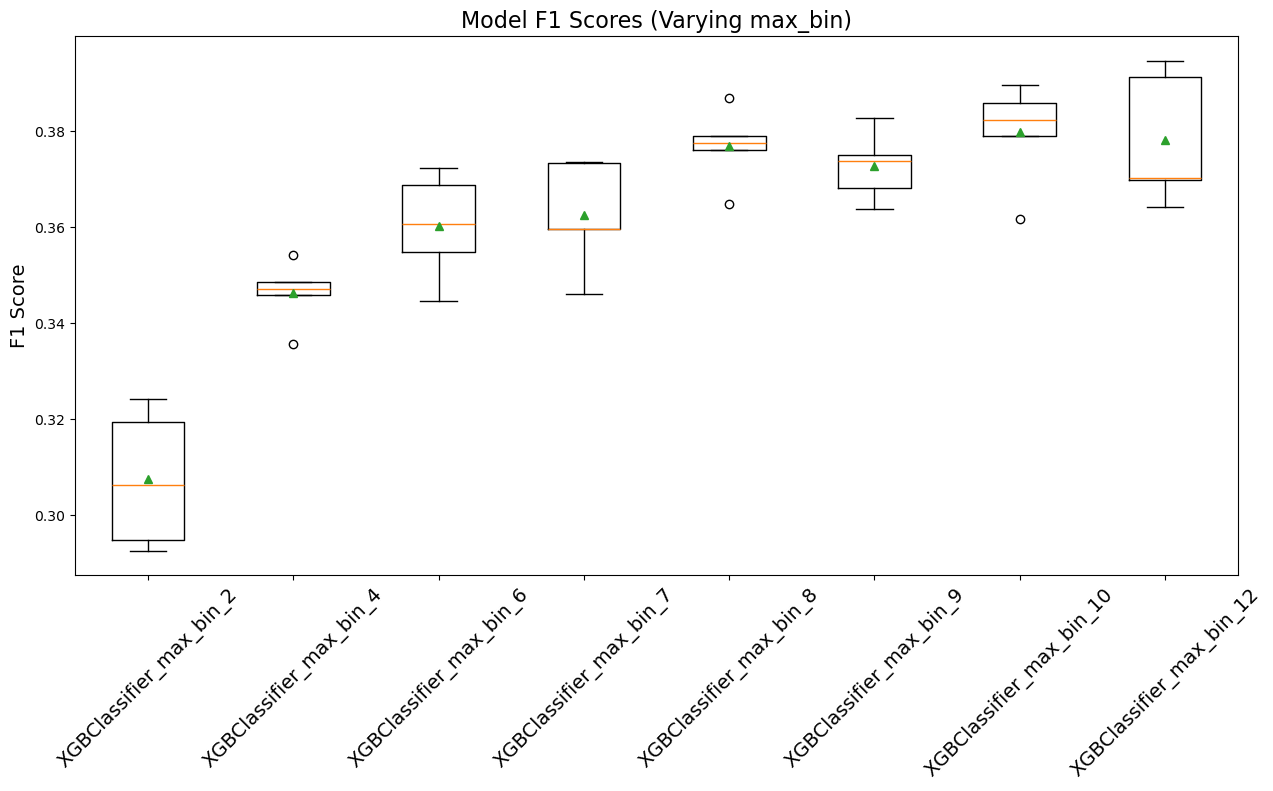

In [51]:
evaluate_models(X_val, y_val, XGBClassifier,param_name="max_bin", param_values=[2,4,6,7,8,9,10,12])

### **LEARNINGRATE** 

Training XGBClassifier_learning_rate_0.05...
>XGBClassifier_learning_rate_0.05: Mean F1 = 0.373, Std F1 = 0.007
Training XGBClassifier_learning_rate_0.1...
>XGBClassifier_learning_rate_0.1: Mean F1 = 0.393, Std F1 = 0.008
Training XGBClassifier_learning_rate_0.2...
>XGBClassifier_learning_rate_0.2: Mean F1 = 0.403, Std F1 = 0.010
Training XGBClassifier_learning_rate_0.3...
>XGBClassifier_learning_rate_0.3: Mean F1 = 0.409, Std F1 = 0.013
Training XGBClassifier_learning_rate_0.4...
>XGBClassifier_learning_rate_0.4: Mean F1 = 0.415, Std F1 = 0.009
Training XGBClassifier_learning_rate_0.5...
>XGBClassifier_learning_rate_0.5: Mean F1 = 0.410, Std F1 = 0.014


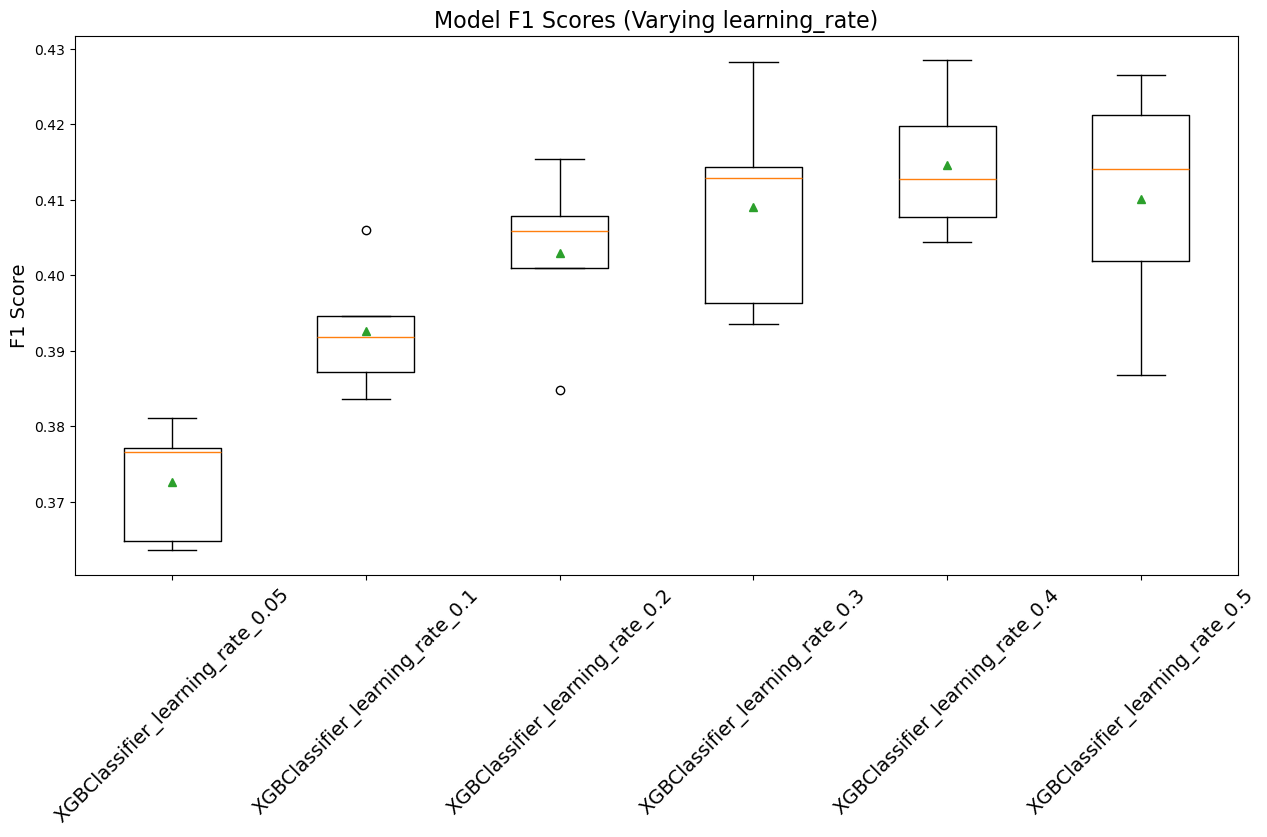

In [52]:
evaluate_models(X_val, y_val, XGBClassifier,param_name="learning_rate", param_values=[0.05,0.1,0.2,0.3,0.4,0.5])

0.4


SubSample

Training XGBClassifier_subsample_0.2...
>XGBClassifier_subsample_0.2: Mean F1 = 0.404, Std F1 = 0.007
Training XGBClassifier_subsample_0.4...
>XGBClassifier_subsample_0.4: Mean F1 = 0.402, Std F1 = 0.004
Training XGBClassifier_subsample_0.6...
>XGBClassifier_subsample_0.6: Mean F1 = 0.401, Std F1 = 0.009
Training XGBClassifier_subsample_0.8...
>XGBClassifier_subsample_0.8: Mean F1 = 0.410, Std F1 = 0.015
Training XGBClassifier_subsample_1...
>XGBClassifier_subsample_1: Mean F1 = 0.409, Std F1 = 0.013


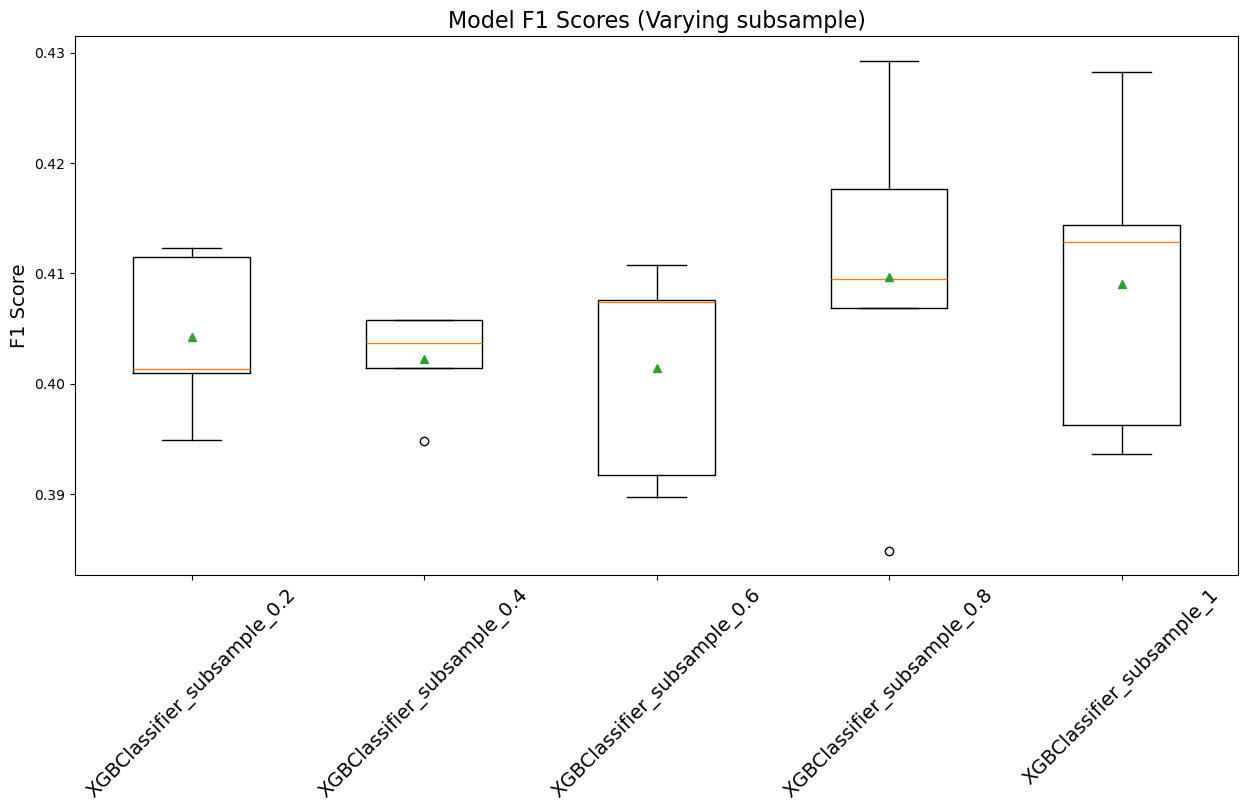

In [53]:
evaluate_models(X_val, y_val, XGBClassifier,param_name="subsample", param_values=[0.2,0.4,0.6,0.8,1])

Colsample_bytree

Training XGBClassifier_colsample_bytree_0.2...
>XGBClassifier_colsample_bytree_0.2: Mean F1 = 0.384, Std F1 = 0.006
Training XGBClassifier_colsample_bytree_0.4...
>XGBClassifier_colsample_bytree_0.4: Mean F1 = 0.404, Std F1 = 0.013
Training XGBClassifier_colsample_bytree_0.6...
>XGBClassifier_colsample_bytree_0.6: Mean F1 = 0.404, Std F1 = 0.012
Training XGBClassifier_colsample_bytree_0.8...
>XGBClassifier_colsample_bytree_0.8: Mean F1 = 0.407, Std F1 = 0.014
Training XGBClassifier_colsample_bytree_1...
>XGBClassifier_colsample_bytree_1: Mean F1 = 0.409, Std F1 = 0.013


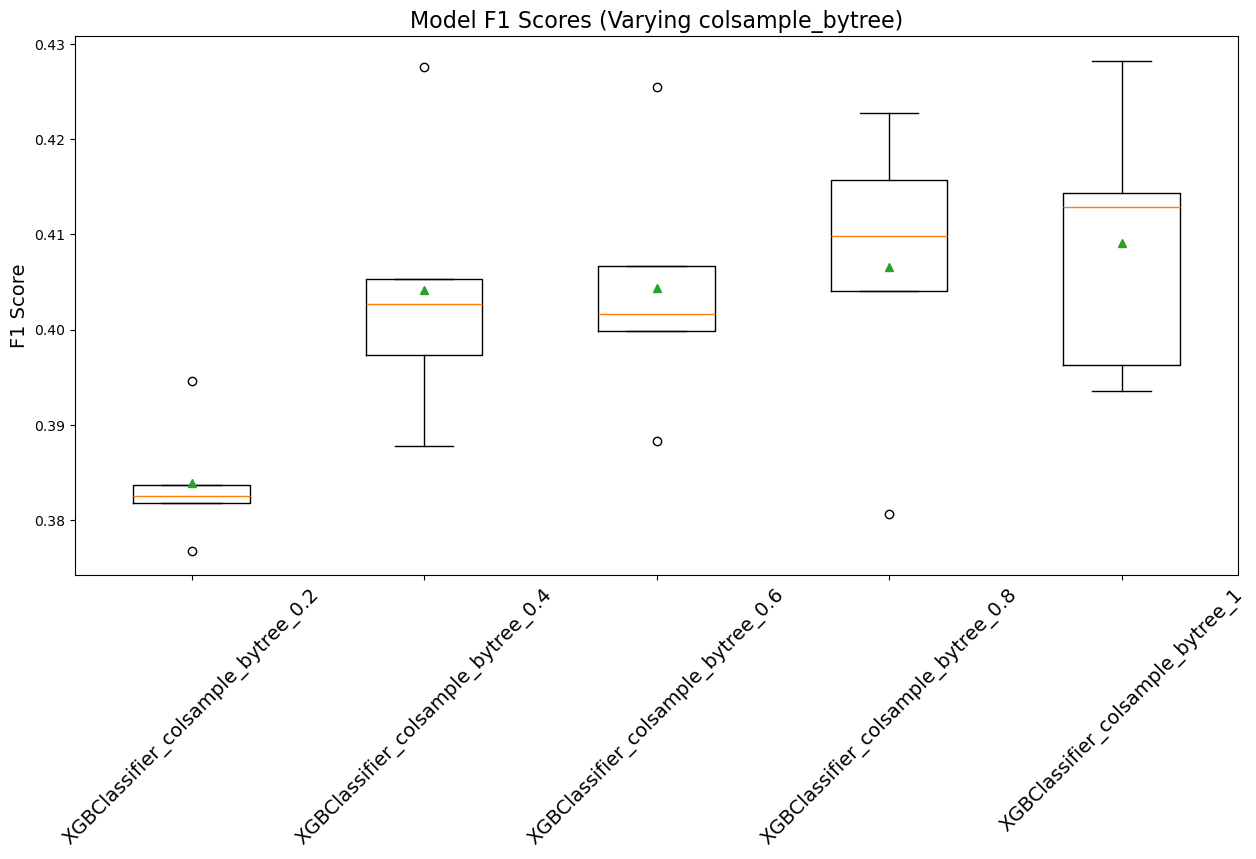

In [54]:
evaluate_models(X_val, y_val, XGBClassifier,param_name="colsample_bytree", param_values=[0.2,0.4,0.6,0.8,1])

1

Training XGBClassifier_min_child_weight_1...
>XGBClassifier_min_child_weight_1: Mean F1 = 0.409, Std F1 = 0.013
Training XGBClassifier_min_child_weight_2...
>XGBClassifier_min_child_weight_2: Mean F1 = 0.407, Std F1 = 0.011
Training XGBClassifier_min_child_weight_3...
>XGBClassifier_min_child_weight_3: Mean F1 = 0.412, Std F1 = 0.015
Training XGBClassifier_min_child_weight_4...
>XGBClassifier_min_child_weight_4: Mean F1 = 0.412, Std F1 = 0.009
Training XGBClassifier_min_child_weight_5...
>XGBClassifier_min_child_weight_5: Mean F1 = 0.416, Std F1 = 0.009
Training XGBClassifier_min_child_weight_7...
>XGBClassifier_min_child_weight_7: Mean F1 = 0.410, Std F1 = 0.010
Training XGBClassifier_min_child_weight_10...
>XGBClassifier_min_child_weight_10: Mean F1 = 0.414, Std F1 = 0.012


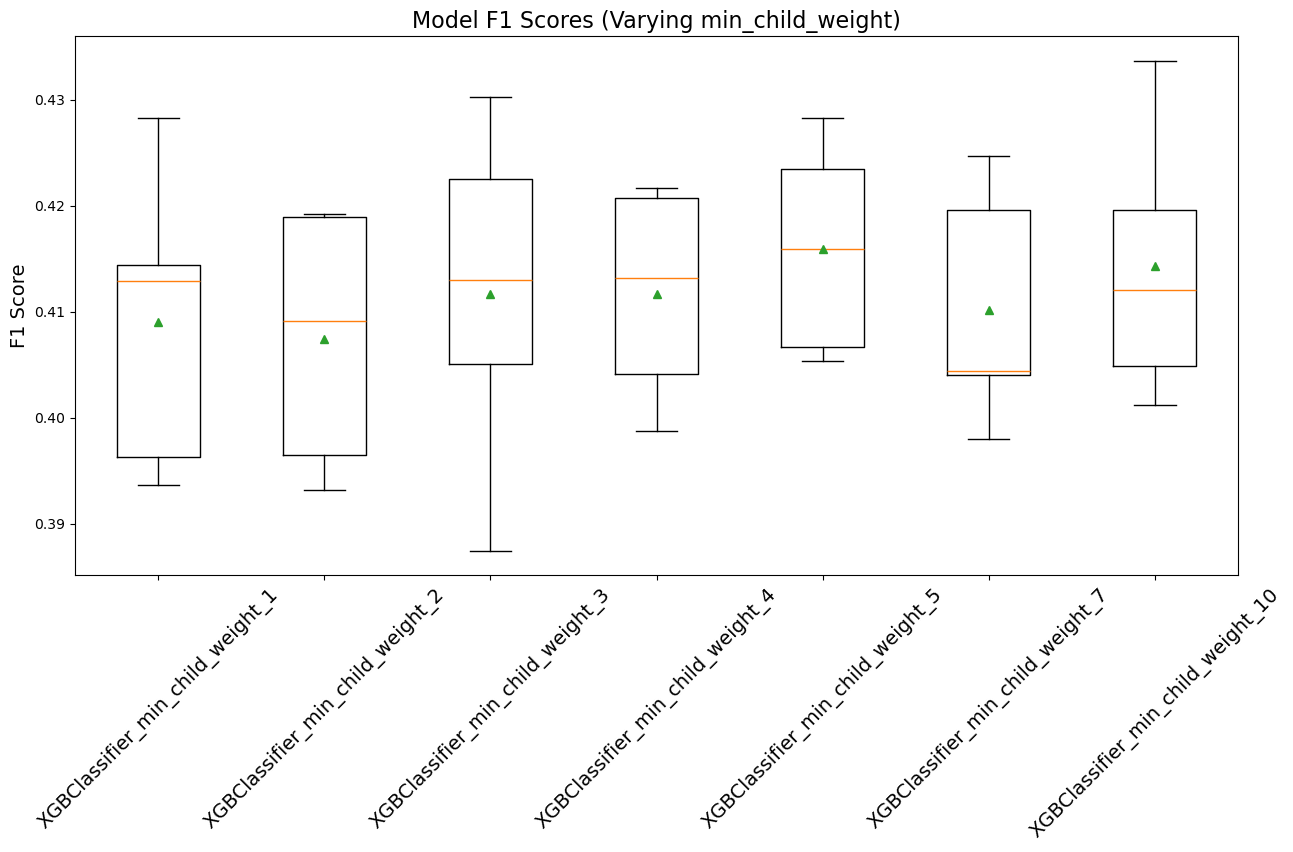

In [55]:
evaluate_models(X_val, y_val, XGBClassifier,param_name="min_child_weight", param_values=[1,2,3,4,5,7,10])

Training XGBClassifier_max_depth_2...
>XGBClassifier_max_depth_2: Mean F1 = 0.376, Std F1 = 0.005
Training XGBClassifier_max_depth_4...
>XGBClassifier_max_depth_4: Mean F1 = 0.403, Std F1 = 0.013
Training XGBClassifier_max_depth_6...
>XGBClassifier_max_depth_6: Mean F1 = 0.409, Std F1 = 0.013
Training XGBClassifier_max_depth_7...
>XGBClassifier_max_depth_7: Mean F1 = 0.407, Std F1 = 0.009
Training XGBClassifier_max_depth_8...
>XGBClassifier_max_depth_8: Mean F1 = 0.412, Std F1 = 0.012
Training XGBClassifier_max_depth_9...
>XGBClassifier_max_depth_9: Mean F1 = 0.410, Std F1 = 0.010
Training XGBClassifier_max_depth_10...
>XGBClassifier_max_depth_10: Mean F1 = 0.409, Std F1 = 0.008
Training XGBClassifier_max_depth_12...
>XGBClassifier_max_depth_12: Mean F1 = 0.402, Std F1 = 0.012


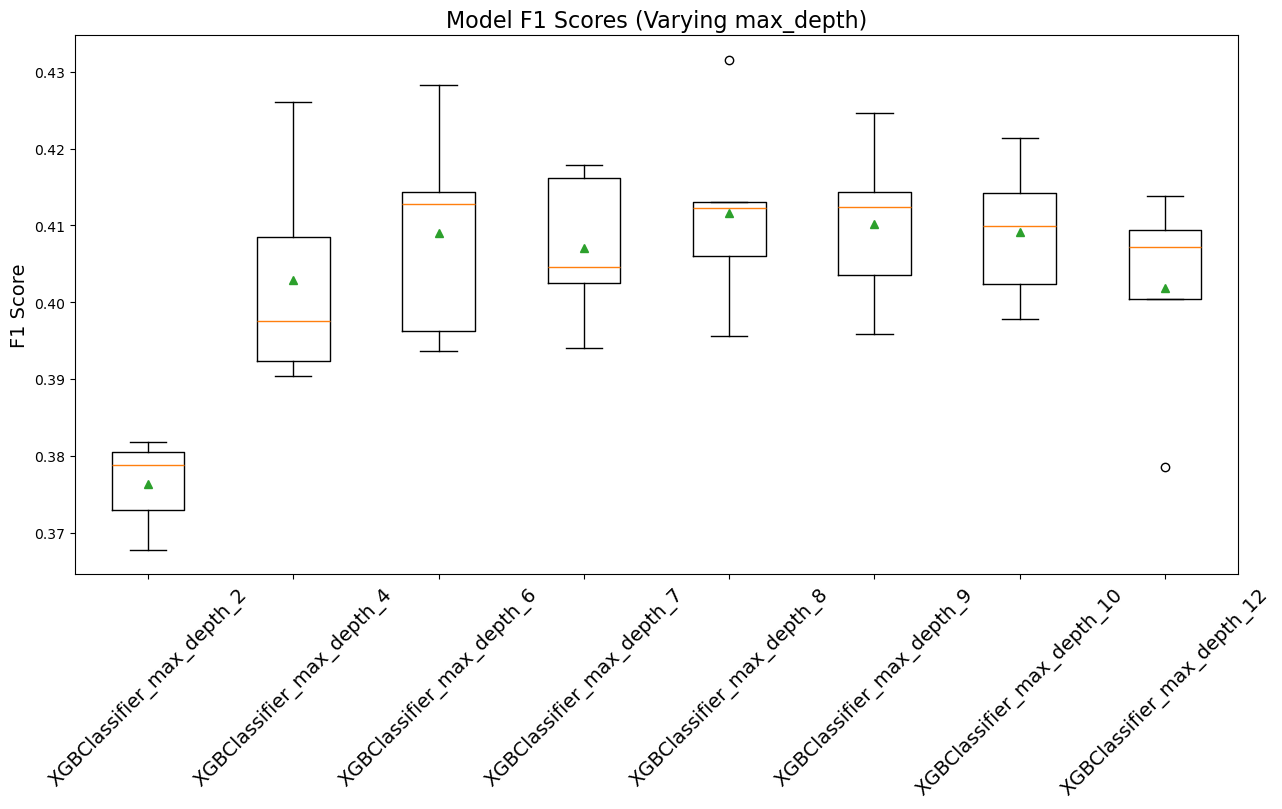

In [56]:
evaluate_models(X_val, y_val, XGBClassifier,param_name="max_depth", param_values=[2,4,6,7,8,9,10,12])

In [57]:
tuned_XGB =  XGBClassifier(n_estimators=150,
 learning_rate=0.1,
 max_depth=8,
 subsample=0.8,  
 colsample_bytree=0.8,
 random_state=42,
 min_child_weight = 3)

In [58]:
with open(f'tuned_XGB.pkl', 'wb') as f:
    pickle.dump(tuned_XGB,f)

### **Best Model with tuning**

In [59]:
model_xgb_tuned = {
    "XGB": tuned_XGB,
}
result_xgb_tuned = trained_models(model_xgb_tuned, X_train, y_train, X_val, y_val)

Training XGB...

Model Evaluation Results:
XGB: Train F1 macro = 0.5688, Train Accuracy = 0.8096, Validation F1 macro = 0.4265, Validation Accuracy = 0.7896


In [60]:
prediction_xgb_tuned = generate_predictions(model_xgb_tuned, test_data_scaled, target_mapping)

Predicting with XGB...
Predictions for XGB saved to 'XGB_predictions.csv'


## 

Tuning Random Forest, to then perform stacking

Training RandomForestClassifier_min_samples_split_2...
>RandomForestClassifier_min_samples_split_2: Mean F1 = 0.376, Std F1 = 0.007
Training RandomForestClassifier_min_samples_split_5...
>RandomForestClassifier_min_samples_split_5: Mean F1 = 0.377, Std F1 = 0.007
Training RandomForestClassifier_min_samples_split_10...
>RandomForestClassifier_min_samples_split_10: Mean F1 = 0.365, Std F1 = 0.004
Training RandomForestClassifier_min_samples_split_20...
>RandomForestClassifier_min_samples_split_20: Mean F1 = 0.357, Std F1 = 0.005
Training RandomForestClassifier_min_samples_split_50...
>RandomForestClassifier_min_samples_split_50: Mean F1 = 0.349, Std F1 = 0.002


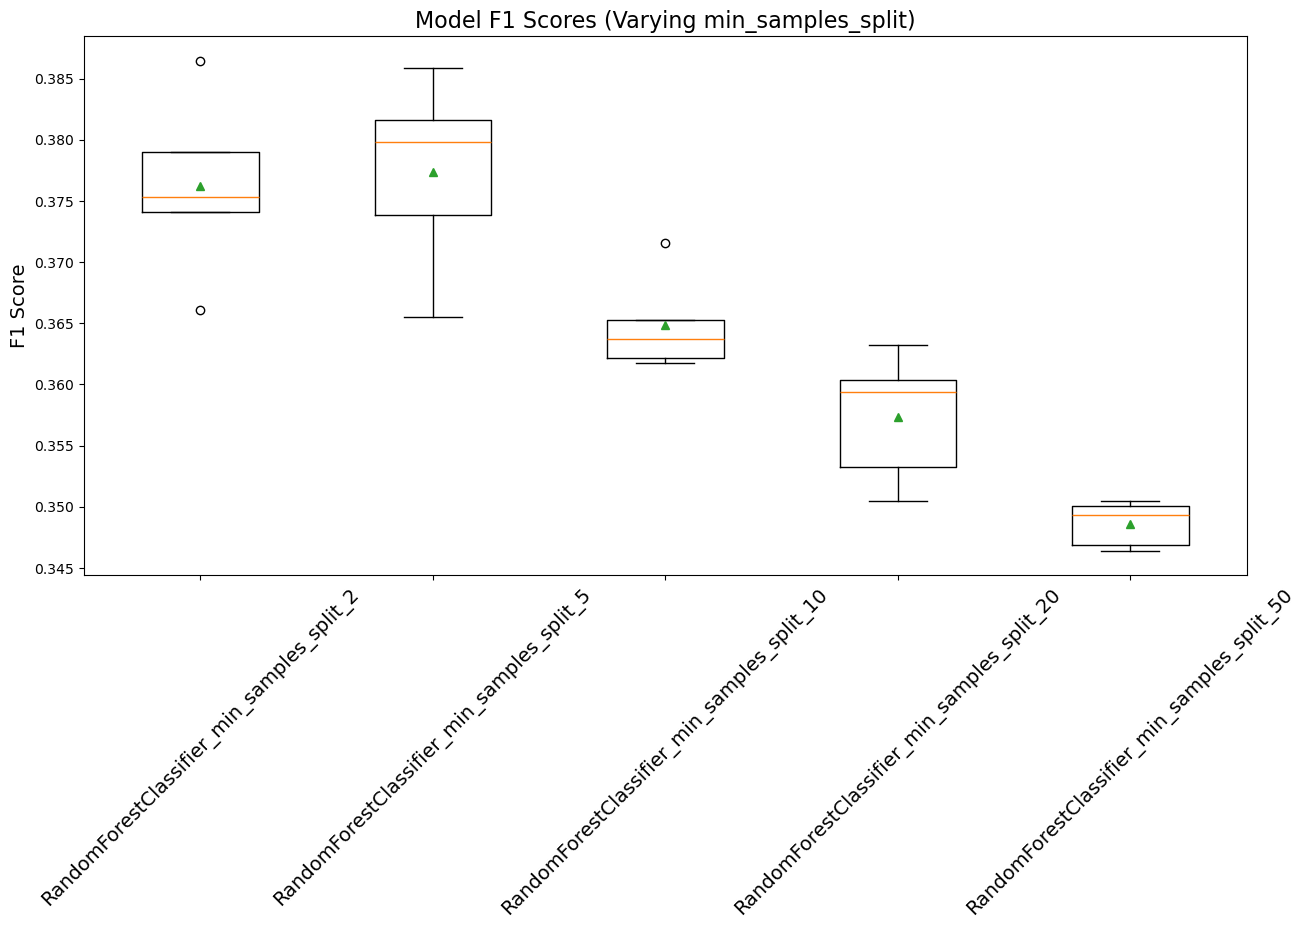

In [61]:
evaluate_models(X_val, y_val, RandomForestClassifier, param_name="min_samples_split", param_values=[2, 5, 10, 20, 50])

min_samples_split=5

Training RandomForestClassifier_min_samples_leaf_1...
>RandomForestClassifier_min_samples_leaf_1: Mean F1 = 0.376, Std F1 = 0.007
Training RandomForestClassifier_min_samples_leaf_2...
>RandomForestClassifier_min_samples_leaf_2: Mean F1 = 0.374, Std F1 = 0.006
Training RandomForestClassifier_min_samples_leaf_5...
>RandomForestClassifier_min_samples_leaf_5: Mean F1 = 0.356, Std F1 = 0.005
Training RandomForestClassifier_min_samples_leaf_10...
>RandomForestClassifier_min_samples_leaf_10: Mean F1 = 0.347, Std F1 = 0.001
Training RandomForestClassifier_min_samples_leaf_20...
>RandomForestClassifier_min_samples_leaf_20: Mean F1 = 0.342, Std F1 = 0.002


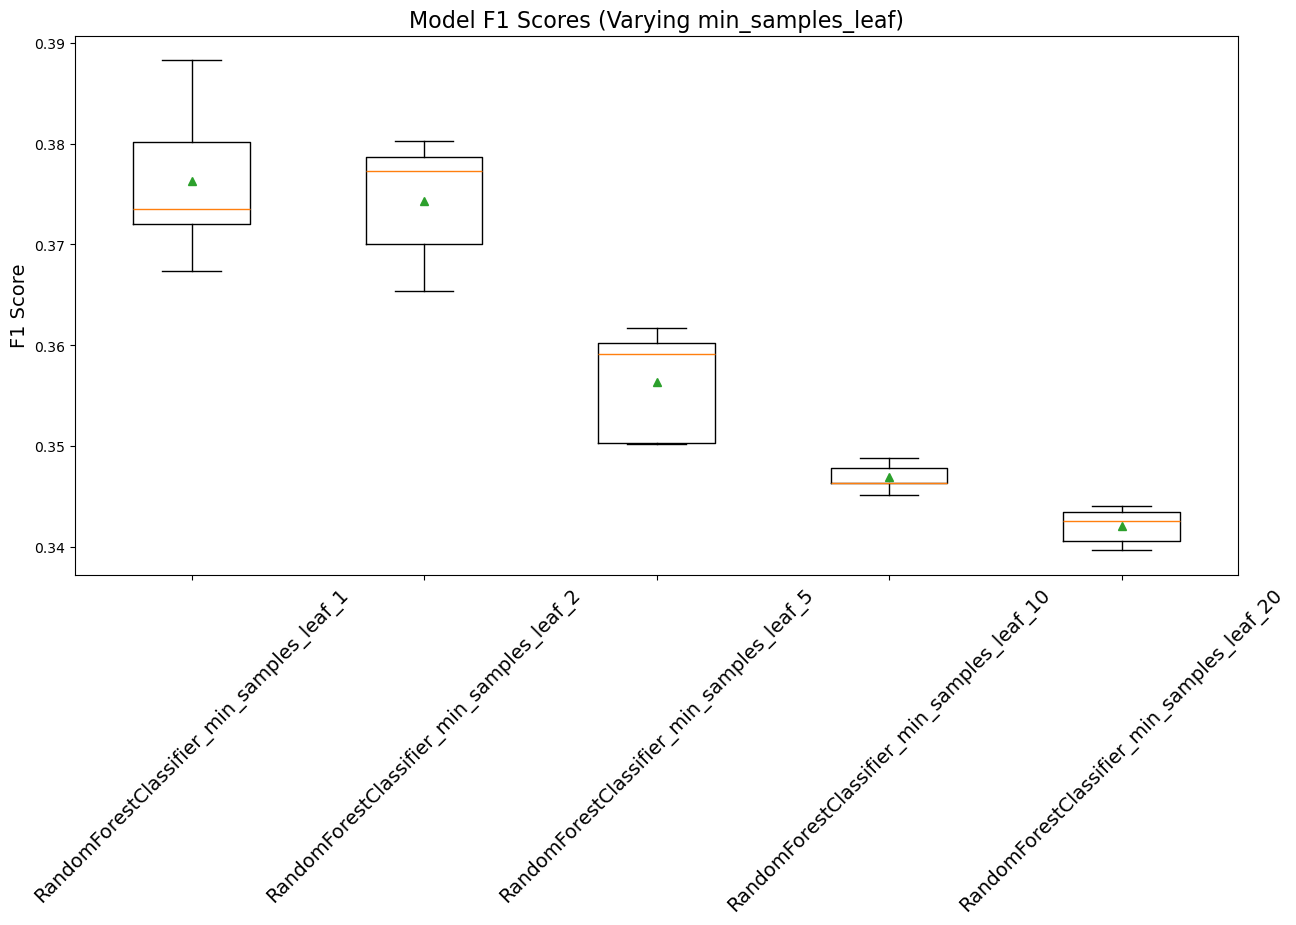

In [62]:
evaluate_models(X_val, y_val, RandomForestClassifier, param_name="min_samples_leaf", param_values=[1, 2, 5, 10, 20])

Training RandomForestClassifier_max_features_sqrt...
>RandomForestClassifier_max_features_sqrt: Mean F1 = 0.378, Std F1 = 0.007
Training RandomForestClassifier_max_features_log2...
>RandomForestClassifier_max_features_log2: Mean F1 = 0.377, Std F1 = 0.006
Training RandomForestClassifier_max_features_0.2...
>RandomForestClassifier_max_features_0.2: Mean F1 = 0.373, Std F1 = 0.008
Training RandomForestClassifier_max_features_0.5...
>RandomForestClassifier_max_features_0.5: Mean F1 = 0.376, Std F1 = 0.007
Training RandomForestClassifier_max_features_None...
>RandomForestClassifier_max_features_None: Mean F1 = 0.380, Std F1 = 0.004


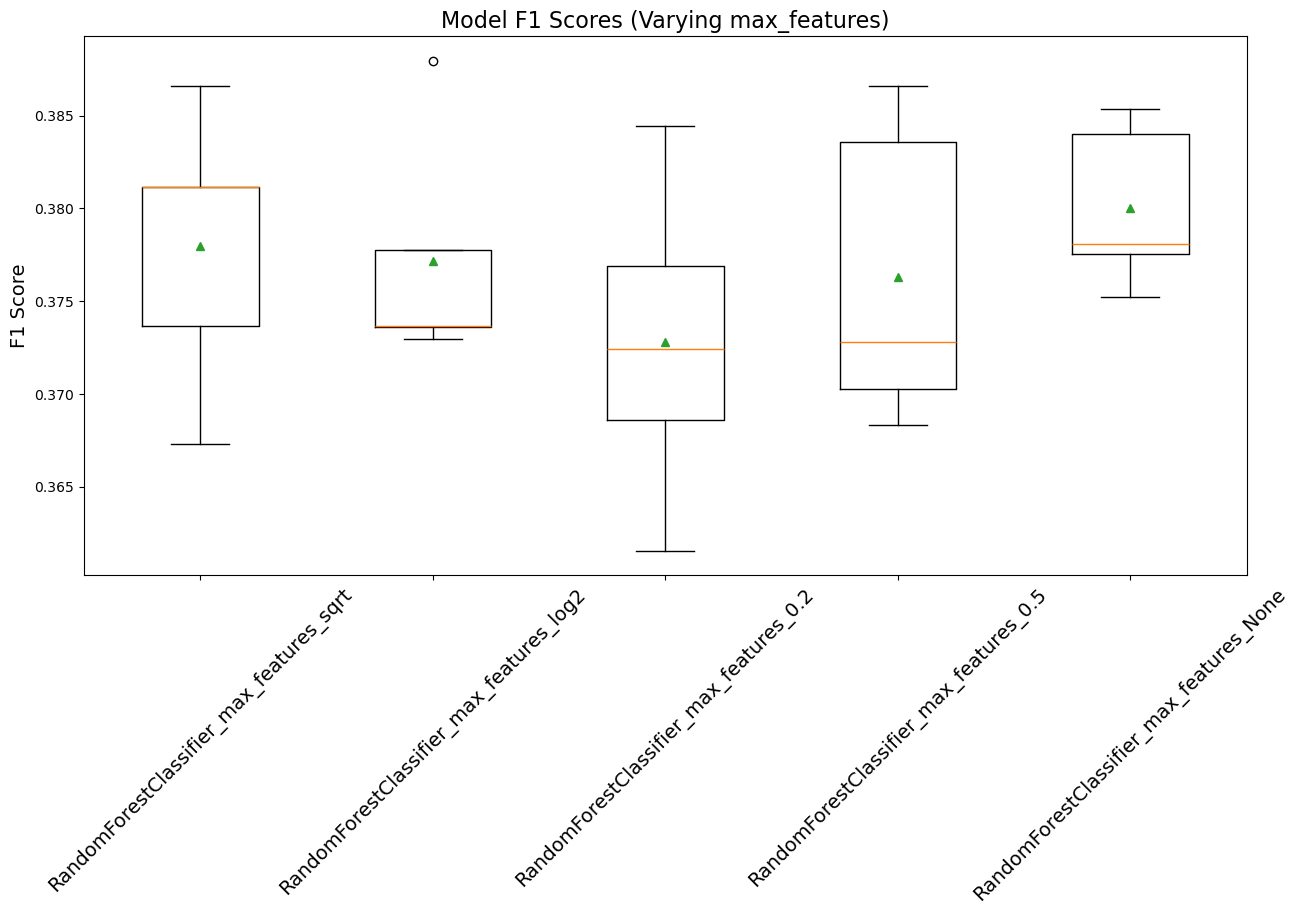

In [63]:
evaluate_models(X_val, y_val, RandomForestClassifier, param_name="max_features", param_values=["sqrt", "log2", 0.2, 0.5, None])

Training RandomForestClassifier_bootstrap_True...
>RandomForestClassifier_bootstrap_True: Mean F1 = 0.378, Std F1 = 0.006
Training RandomForestClassifier_bootstrap_False...
>RandomForestClassifier_bootstrap_False: Mean F1 = 0.386, Std F1 = 0.006


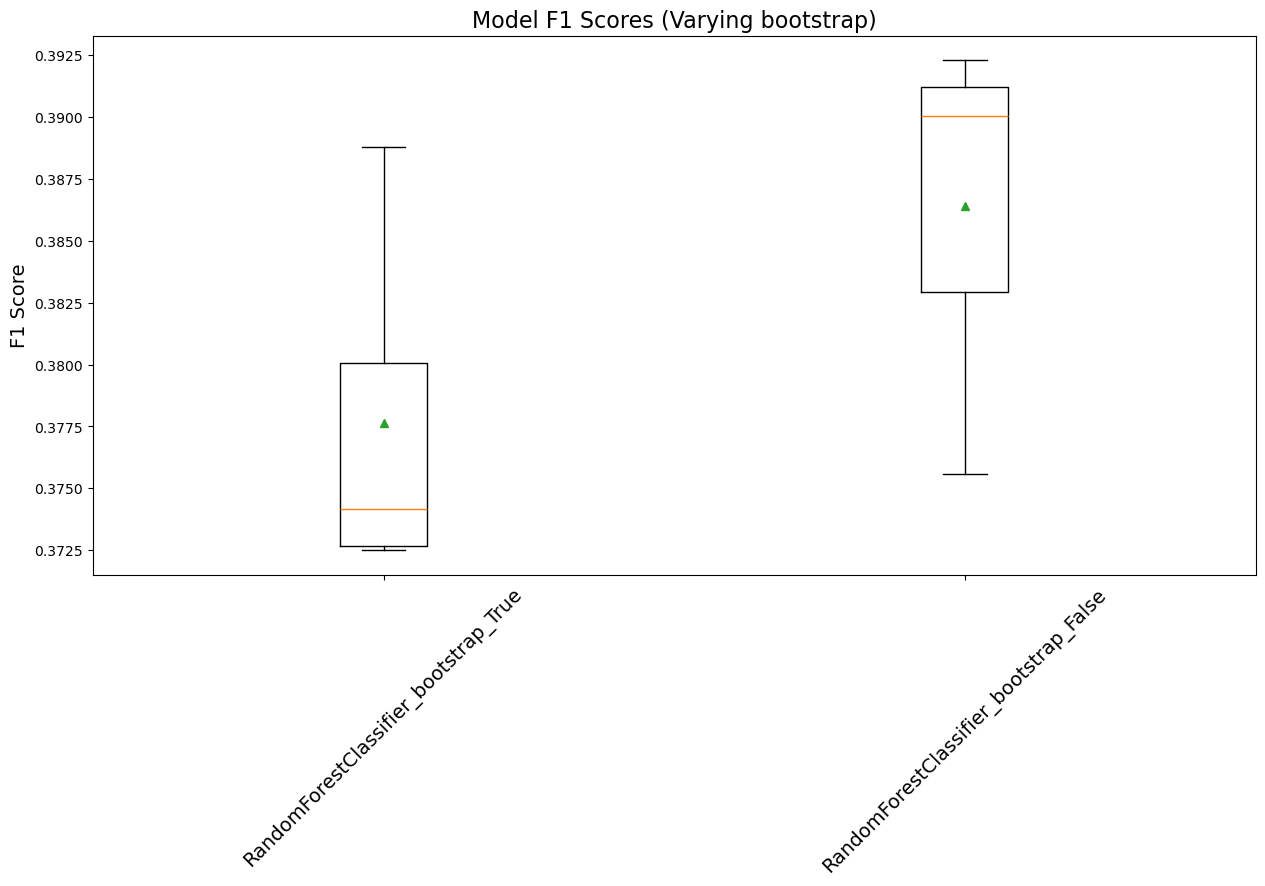

In [64]:
evaluate_models(X_val, y_val, RandomForestClassifier, param_name="bootstrap", param_values=[True, False])

Training RandomForestClassifier_class_weight_balanced...
>RandomForestClassifier_class_weight_balanced: Mean F1 = 0.372, Std F1 = 0.010
Training RandomForestClassifier_class_weight_balanced_subsample...
>RandomForestClassifier_class_weight_balanced_subsample: Mean F1 = 0.372, Std F1 = 0.011
Training RandomForestClassifier_class_weight_None...
>RandomForestClassifier_class_weight_None: Mean F1 = 0.373, Std F1 = 0.008


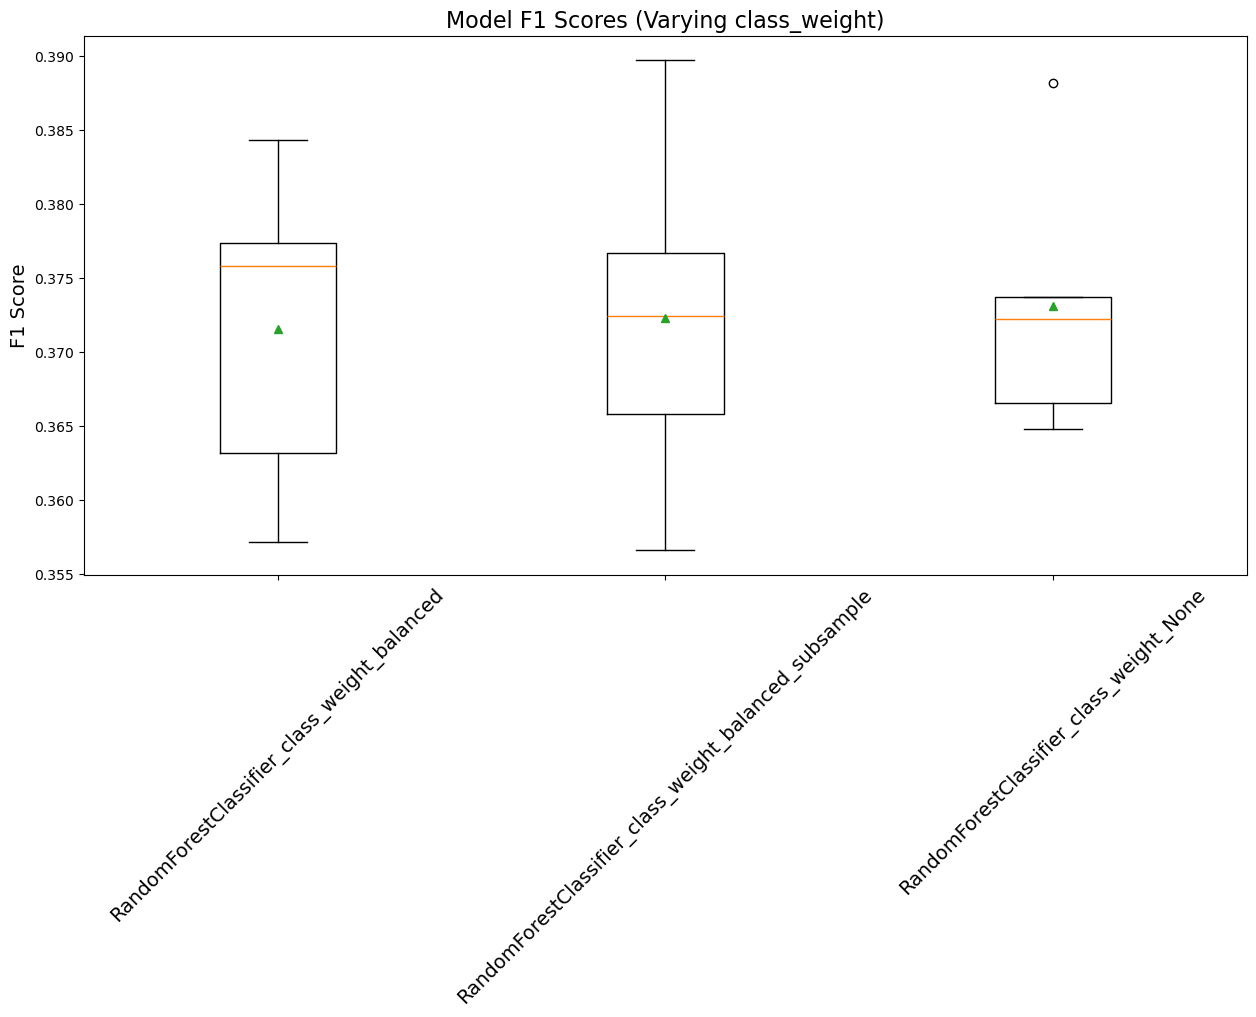

In [65]:
evaluate_models(X_val, y_val, RandomForestClassifier, param_name="class_weight", param_values=["balanced", "balanced_subsample", None])

Training RandomForestClassifier_max_leaf_nodes_None...
>RandomForestClassifier_max_leaf_nodes_None: Mean F1 = 0.377, Std F1 = 0.008
Training RandomForestClassifier_max_leaf_nodes_10...
>RandomForestClassifier_max_leaf_nodes_10: Mean F1 = 0.234, Std F1 = 0.002
Training RandomForestClassifier_max_leaf_nodes_50...
>RandomForestClassifier_max_leaf_nodes_50: Mean F1 = 0.288, Std F1 = 0.006
Training RandomForestClassifier_max_leaf_nodes_100...
>RandomForestClassifier_max_leaf_nodes_100: Mean F1 = 0.313, Std F1 = 0.002
Training RandomForestClassifier_max_leaf_nodes_200...
>RandomForestClassifier_max_leaf_nodes_200: Mean F1 = 0.324, Std F1 = 0.002


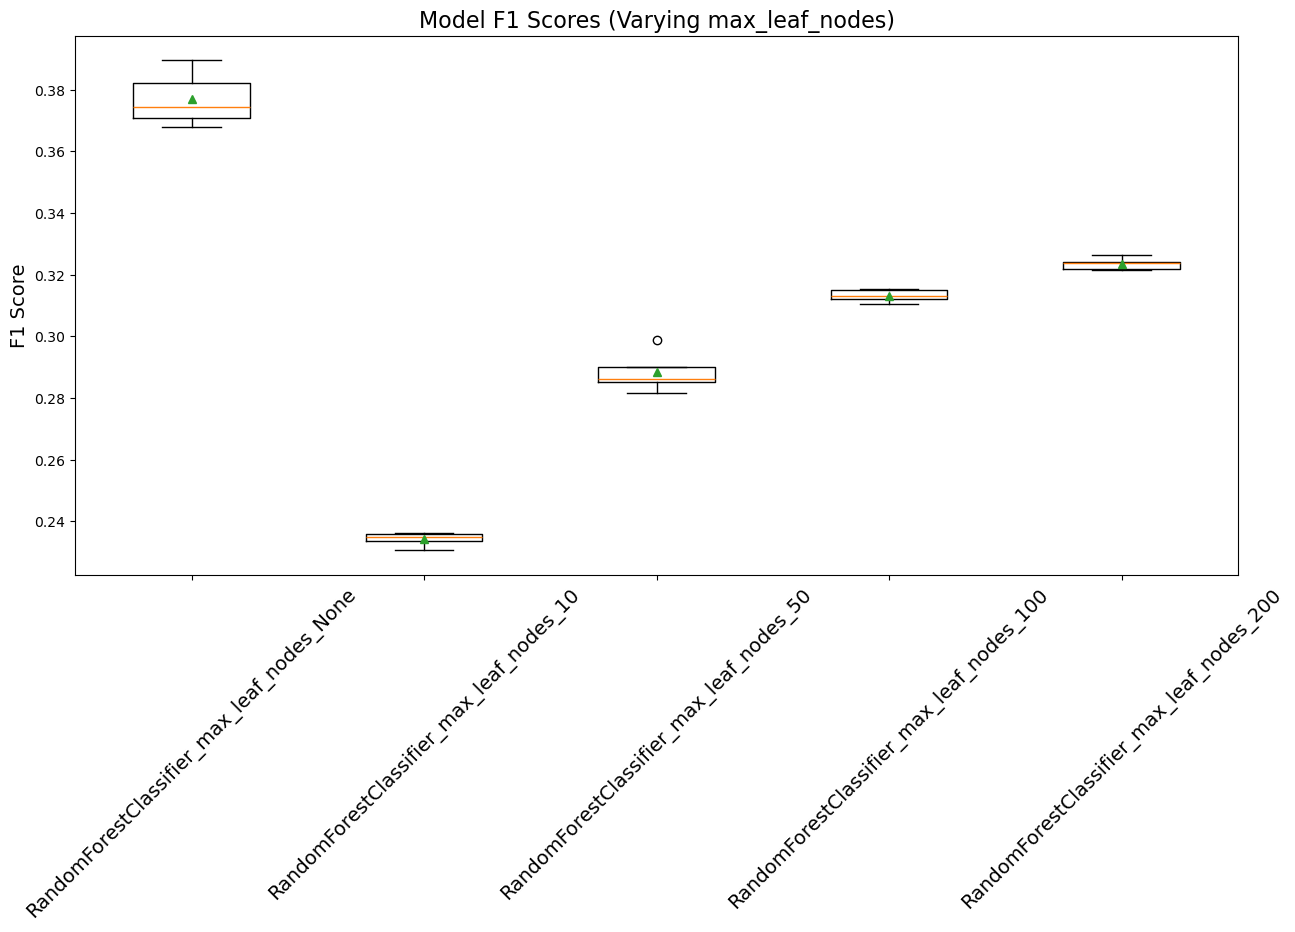

In [66]:
evaluate_models(X_val, y_val, RandomForestClassifier, param_name="max_leaf_nodes", param_values=[None, 10, 50, 100, 200])

Training RandomForestClassifier_n_estimators_50...
>RandomForestClassifier_n_estimators_50: Mean F1 = 0.374, Std F1 = 0.004
Training RandomForestClassifier_n_estimators_100...
>RandomForestClassifier_n_estimators_100: Mean F1 = 0.376, Std F1 = 0.007
Training RandomForestClassifier_n_estimators_200...
>RandomForestClassifier_n_estimators_200: Mean F1 = 0.377, Std F1 = 0.007
Training RandomForestClassifier_n_estimators_300...
>RandomForestClassifier_n_estimators_300: Mean F1 = 0.373, Std F1 = 0.005
Training RandomForestClassifier_n_estimators_400...
>RandomForestClassifier_n_estimators_400: Mean F1 = 0.376, Std F1 = 0.008
Training RandomForestClassifier_n_estimators_500...
>RandomForestClassifier_n_estimators_500: Mean F1 = 0.378, Std F1 = 0.007


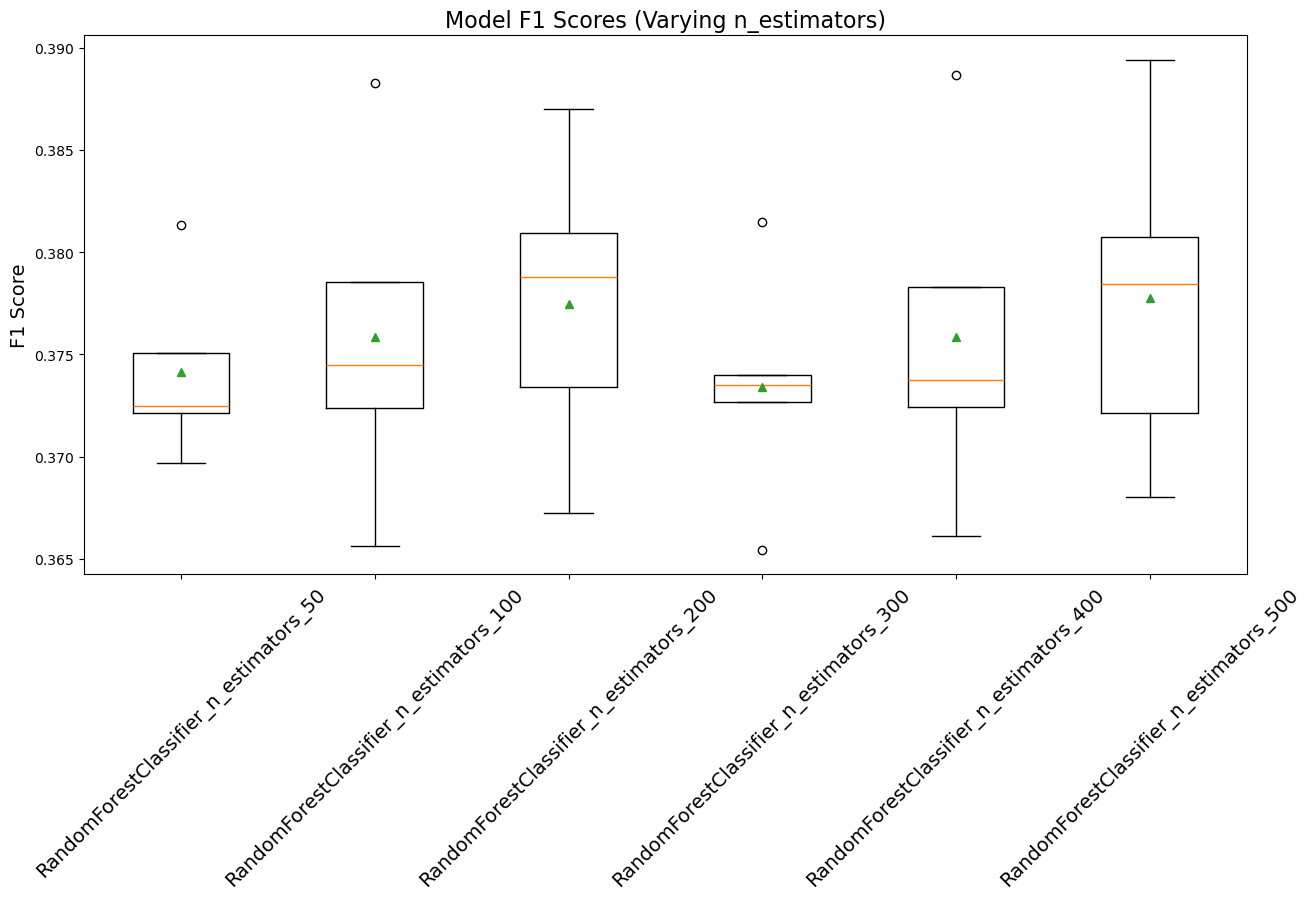

In [67]:
evaluate_models(X_val, y_val, RandomForestClassifier, param_name="n_estimators", param_values=[50, 100, 200, 300, 400, 500])

In [68]:
tuned_RF =  RandomForestClassifier(
min_samples_leaf=1,
min_samples_split=2,
max_features= None,  
bootstrap=True, 
random_state=42,
class_weight=None,
max_leaf_nodes=None,
n_estimators=300)

In [69]:
model_rf_tuned = {
    "Random Forest": tuned_RF,
}
result_rf_tuned = trained_models(model_rf_tuned, X_train, y_train, X_val, y_val)

Training Random Forest...

Model Evaluation Results:
Random Forest: Train F1 macro = 1.0000, Train Accuracy = 1.0000, Validation F1 macro = 0.3902, Validation Accuracy = 0.7821


In [70]:
prediction_rf_tuned = generate_predictions(model_rf_tuned, test_data_scaled, target_mapping)

Predicting with Random Forest...
Predictions for Random Forest saved to 'Random Forest_predictions.csv'


Stacking both tuned models

In [71]:
from sklearn.ensemble import StackingClassifier

In [72]:
estimators = [('xgb', tuned_XGB),
              ('rf', tuned_RF)]

In [73]:
st = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier()).fit(X_train, y_train)

In [74]:
model_st = {
    'Stacking': st,
}
result_st = trained_models(model_st, X_train, y_train, X_val, y_val)

Training Stacking...

Model Evaluation Results:
Stacking: Train F1 macro = 0.5575, Train Accuracy = 0.8319, Validation F1 macro = 0.4146, Validation Accuracy = 0.7886


In [75]:
prediction_st = generate_predictions(model_st, test_data_scaled, target_mapping)

Predicting with Stacking...
Predictions for Stacking saved to 'Stacking_predictions.csv'
